<a href="https://colab.research.google.com/github/Deepak4053/Image_Style_Transfer/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

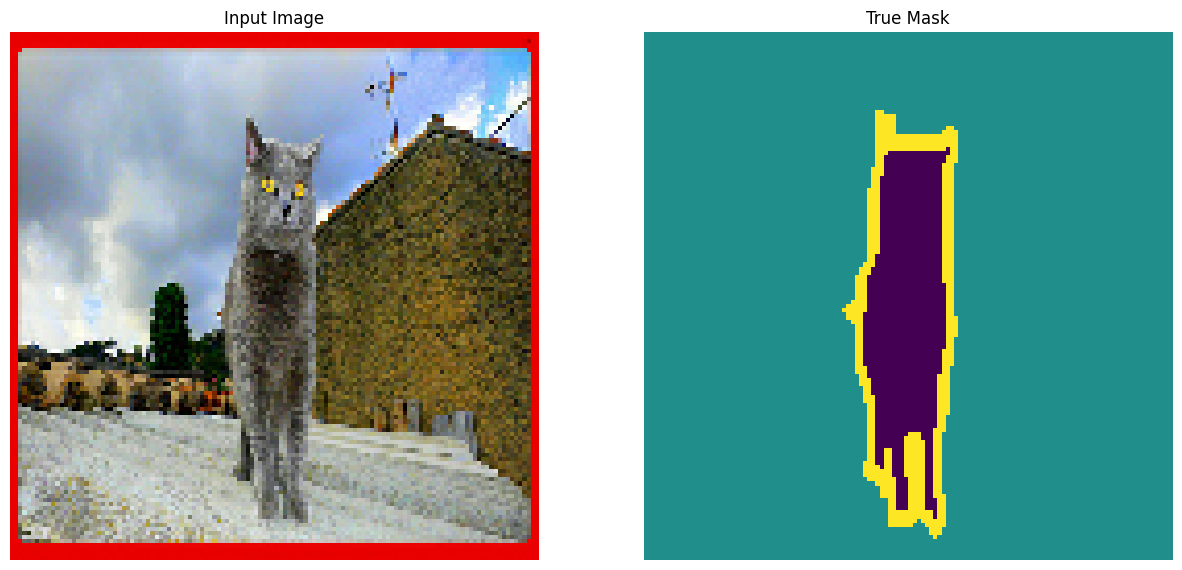

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model():  # Add a function name
    # inputs
    inputs = layers.Input(shape=(128, 128, 3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model=build_unet_model()


In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]) # Change metrics to a list

In [ ]:

NUM_EPOCHS = 5

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples  # Corrected variable name: TEST_LENTH to TEST_LENGTH
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

# Ensure test_batches is reset or recreated before each epoch to avoid data exhaustion
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    # Reset or recreate test_batches here, e.g., test_batches = test_dataset.batch(BATCH_SIZE)
    model_history = unet_model.fit(
        train_batches,
        epochs=1,  # Train for a single epoch within the loop
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        validation_data=test_batches,
    )

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7584 - loss: 0.6045 - val_accuracy: 0.7831 - val_loss: 0.5469
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7833 - loss: 0.5503 - val_accuracy: 0.8076 - val_loss: 0.4922
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8042 - loss: 0.5044 - val_accuracy: 0.8101 - val_loss: 0.4850
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8170 - loss: 0.4733 - val_accuracy: 0.8343 - val_loss: 0.4322
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8336 - loss: 0.4314 - val_accuracy: 0.8409 - val_loss: 0.4134


Number of batches: 11
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step


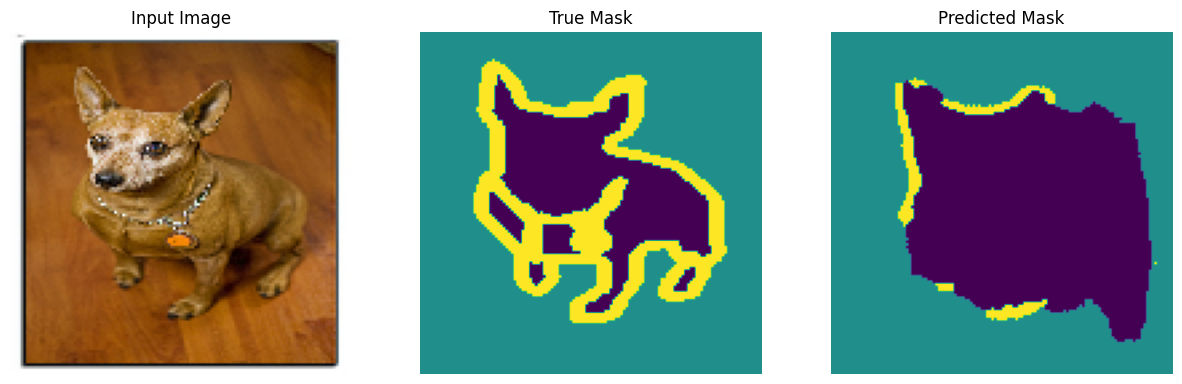

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


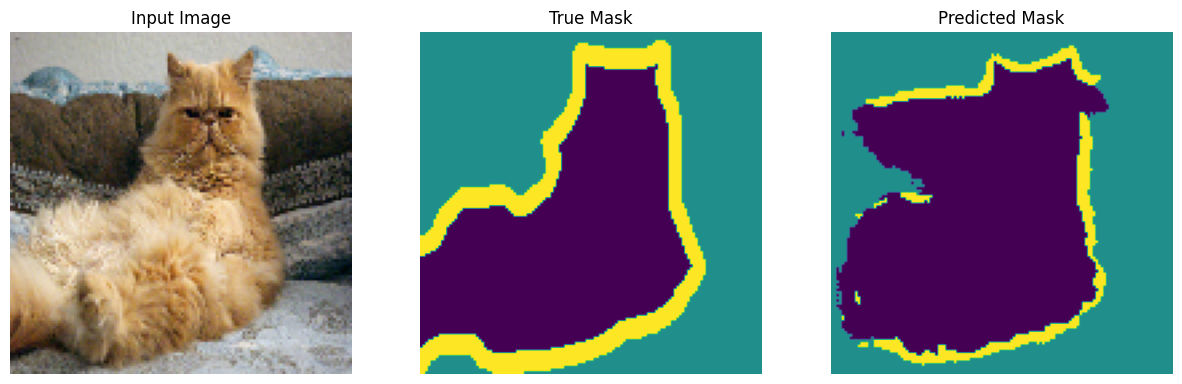

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


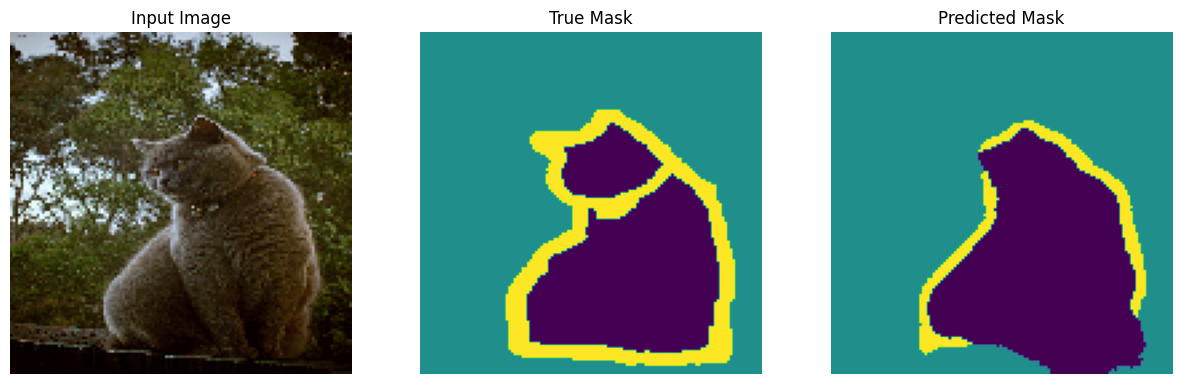

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create a mask from the predicted probabilities
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)  # Find the class with the highest probability
    pred_mask = pred_mask[..., tf.newaxis]     # Add an extra dimension for proper shape
    return pred_mask[0]                        # Return the first prediction mask (batch size might be >1)

# Function to show the input image, true mask, and predicted mask
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)  # Predict the segmentation mask
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        # In case of sample image not from dataset
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Function to display the input image, true mask, and predicted mask
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    # Loop over the 3 images (Input, True, and Predicted)
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)  # Create subplot for each
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')  # Hide axes

    plt.show()

# Counting number of batches in the test set
count = 0
for i in test_batches:
    count += 1
print("Number of batches:", count)

# Visualizing the first few predictions from the dataset
show_predictions(test_batches, num=3)
